Simple stat-arb example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import yfinance as yf

Reading data from Yahoo Finance:

In [2]:
def read_stock_data(ticker):

    data = yf.download(ticker, start = '2010-01-01', end = '2024-08-01')

    data['log_ret'] = np.log(data['Close']).diff()

    return pd.DataFrame(data['log_ret'].dropna())

In [3]:
data1 = read_stock_data('V')
data2 = read_stock_data('MA')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Functions for calculating standard statistics on the daily equity curve:

In [41]:
days_in_year = 252

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

In [4]:
def strategy_backtest(data, params, plot = False, in_sample_end = '', slippage = 0.0005, plot_position = True):
    """
    Strategy backtest calculation

    :data: dataframe with log returns
    :params: list of strategy parameters
    :plot: if True than equity curve is plotted
    :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
    :slippage: slippage per trade
    :plot_position: if True than position values is plotted
    :return: statistics and equity curve
    """

    # Strategy parameters that we will optimize
    period = params[0]
    open_treshold = params[1]
    close_treshold = params[1]*params[2]

    period2 = params[3]

    pos_limit =  params[4]

    # Calculation of target position:
    features = pd.DataFrame(index = data.index)
    features['spread'] = data['log_ret'].cumsum()

    features['spread_mean'] = features['spread'].ewm(period).mean()
    features['spread_std'] =  np.abs(features['spread'] - features['spread_mean']).ewm(period).mean()
    features['z_score'] = ((features['spread'] - features['spread_mean'])/features['spread_std']).fillna(0)
    features['position'] = 5*(-features['z_score']).ewm(period2).mean()

    features['position'] = features['position'].shift(1).fillna(0).astype(int)

    # Maximum position limit
    features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
    features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')
    bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

    turnover = features['position'].diff().abs().sum()

    # We calculate statistics and save the result
    stats = statistics_calc(eq, bh, name = "{0}_{1}_{2}".format(period, open_treshold, close_treshold), plot = plot)

    # Draw a graph of position changes, if necessary
    if (plot) and (plot_position):

        if in_sample_end != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

        period_to_plot = 500
        plt.figure(figsize = (10, 4))
        plt.plot(features['spread'][-period_to_plot:], label = 'Spread value')
        plt.plot(features['spread_mean'][-period_to_plot:], color = 'tab:orange')
        plt.plot((features['spread_mean']+features['spread_std'])[-period_to_plot:], color = 'tab:orange', label = 'Moving average and Std range')
        plt.plot((features['spread_mean']-features['spread_std'])[-period_to_plot:], color = 'tab:orange')
        plt.legend()

        plt.figure()
        plt.figure(figsize = (10, 4))
        plt.plot(features['z_score'].ewm(period2).mean()[-period_to_plot:], label = 'z-score')

        position_to_plot = features['position'][-period_to_plot:]
        plt.plot(position_to_plot, label = 'position')
        plt.xlabel('t')
        plt.legend()

    return stats, eq, turnover

In [5]:
def opt_backtest(train, params):
    stats_current, *_ = strategy_backtest(train, params)
    return stats_current['Sharpe ratio'].iloc[0]

In [6]:
def objective(trial):

    period = trial.suggest_int("period", 5, 5000, log = True)
    open_treshold = trial.suggest_float("open_treshold", 1.0, 3.0)
    close_treshold = trial.suggest_float("close_treshold", 0.0005, 0.8)
    period2 = trial.suggest_int("period2", 5, 2000, log = True)

    pos_limit = trial.suggest_int("pos_limit", 1, 5)

    beta = trial.suggest_float("beta", 0.02, 5.0, log = True)

    data = (data1-beta*data2).dropna()

    in_sample_start = '2016-01-01'
    in_sample_end = '2023-01-01'

    train = data[in_sample_start:in_sample_end]

    obj_value = opt_backtest(train, [period, open_treshold, close_treshold, period2, pos_limit])

    if np.isnan(obj_value):
        obj_value = 0

    return obj_value

  0%|          | 0/500 [00:00<?, ?it/s]

Sharpe ratio = 1.29
Annual Return = 0.27
Annual Std = 0.21


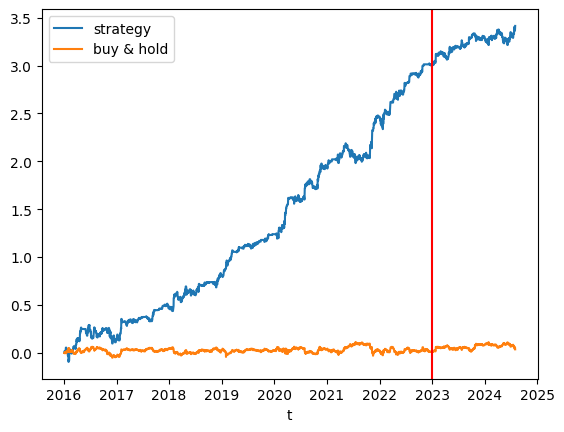

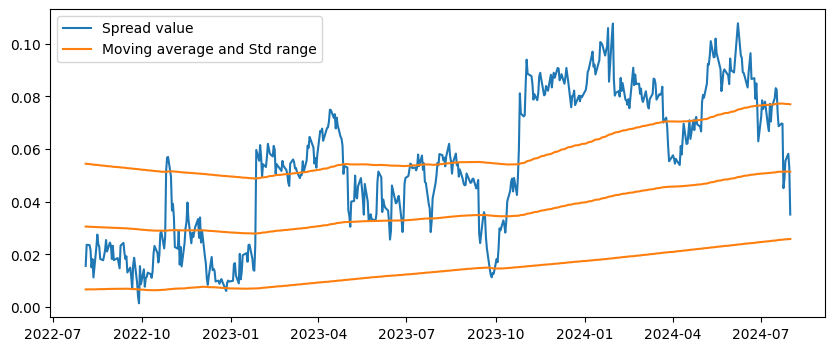

<Figure size 640x480 with 0 Axes>

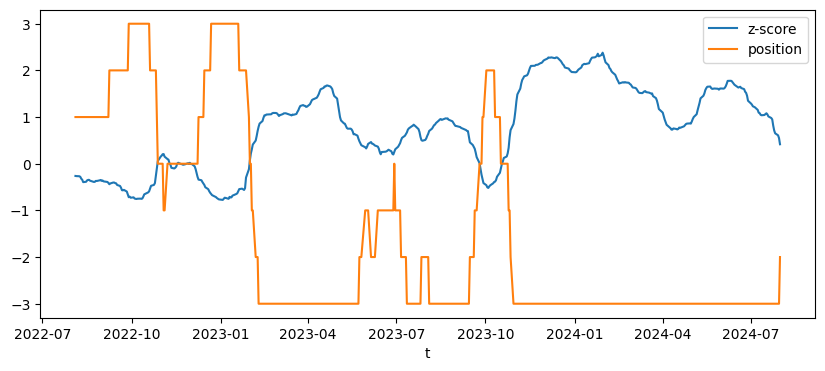

In [10]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 500, show_progress_bar = True)
params = list(study.best_params.values())

data = (data1-study.best_params['beta']*data2).dropna()
in_sample_start = '2016-01-01'
in_sample_end = '2023-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_start:]
stats, eq, _ = strategy_backtest(test, params, True, in_sample_end)


In [13]:
study.best_params

{'period': 426,
 'open_treshold': 1.3160911594379505,
 'close_treshold': 0.203241987209354,
 'period2': 8,
 'pos_limit': 3,
 'beta': 0.7778117651487991}

Additional exercises and research topics:

1. Develop and test your own statistical arbitrage strategy (you can use any instruments combinations, including creating them dynamically)

# Обобщим поиск наиболее коррелированных пар активов

In [7]:
def read_stock_data(ticker):
    data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
    data["log_ret"] = np.log(data["Close"]).diff()
    return data[["log_ret"]].dropna()

In [107]:
# Список акций из XLF
xlf_tickers = [
    "JPM", "BAC", "WFC", "C", "GS", "MS", "USB", "PNC", "TFC", "SCHW",
    "CB", "MET", "AIG", "PRU", "BK", "STT", "AFL", "LNC", "NTRS", "CINF"
]

returns = pd.concat([read_stock_data(ticker).rename(columns={"log_ret": ticker}) for ticker in xlf_tickers], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

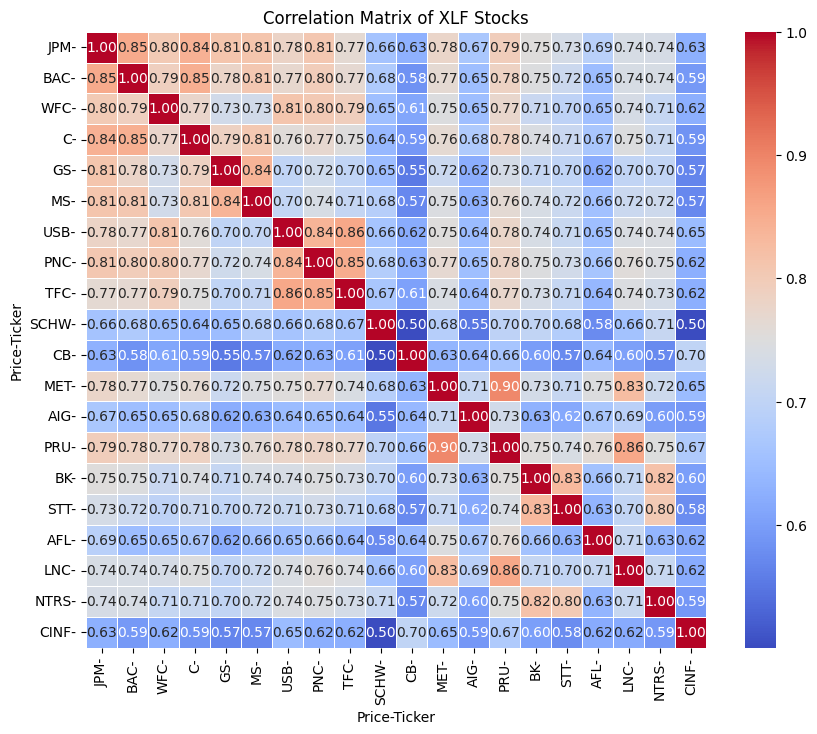

In [108]:
# Вычисление корреляционной матрицы
corr_matrix = returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of XLF Stocks")
plt.show()


Выберем теперь наиболее коррелирующие пары активов, которые мы будем потом торговать. У наиболее коррелирующих активов больше шанс возвращения к среднему.

In [32]:
threshold = 0.85
pairs_corr_assets = [(t1[0], t2[0], corr_matrix.loc[t1, t2])
                    for t1 in corr_matrix.columns for t2 in corr_matrix.columns
                    if t1 != t2 and corr_matrix.loc[t1, t2] >= threshold]
print("\nВысококоррелированные пары (ρ > 0.85):")
for t1, t2, corr in sorted(pairs_corr_assets, key=lambda x: -x[2]):
    print(f"{t1} - {t2}: {corr:.3f}")


Высококоррелированные пары (ρ > 0.85):
MET - PRU: 0.896
PRU - MET: 0.896
PRU - LNC: 0.857
LNC - PRU: 0.857
USB - TFC: 0.856
TFC - USB: 0.856
JPM - BAC: 0.853
BAC - JPM: 0.853
PNC - TFC: 0.851
TFC - PNC: 0.851


# Теперь проведем более детальный отбор пар стратегий (c учетом родственности различных ETFs)

Я вручную взял топ 15-20 активов из соответстующих ETF (XLF, XLRE, KRE, IAK), которые являются родственными. 
Проведу теперь кластеризацию всех активов, чтобы выделить группы, которые ведут себя похоже. Далее для каждого кластера проведу подсчет корреляций активов и выберу по некоторому порогу наиболее коррелирующие пары. И последним этапом воронки перед самим тестированием стратегий будет проверка статистических тестов на наличие коинтеграции спреда пары активов.

"Хорошие" пары активов мы будем тестировать стратегией возврата к среднему. Также я попробую провести тестирование стратегии более умного хеджирования (динамического).

In [8]:
xlf_assets = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP', 'BRK.B', 'BLK', 'SPGI', 'AIG', 'PRU', 'SCHW', 'MET', 'TROW', 'USB', 'CME', 'HIG', 'FNF']
xlre_assets = ['PLD', 'AMT', 'CCI', 'EQIX', 'SPG', 'PSA', 'O', 'REG', 'WELL', 'VTR', 'BXP', 'DLR', 'EQR', 'ESS', 'AVB', 'HCP']
kre_assets = ['FRC', 'ZION', 'TFC', 'SIVB', 'PACW', 'WTFC', 'HBAN', 'FNB', 'KEY', 'BOKF', 'STT', 'USB', 'CMA', 'CIT', 'PFS', 'PBCT']
iak_assets = ['AIG', 'MET', 'PRU', 'HIG', 'TRV', 'BHF', 'LNC', 'PGR', 'WRB', 'RE', 'MGIC', 'CINF', 'ACGL', 'ALL', 'GL', 'RGA']

returns_xlf = pd.concat([read_stock_data(ticker).rename(columns={"log_ret": ticker}) for ticker in xlf_assets], axis=1)
returns_xlre = pd.concat([read_stock_data(ticker).rename(columns={"log_ret": ticker}) for ticker in xlre_assets], axis=1)
returns_kre = pd.concat([read_stock_data(ticker).rename(columns={"log_ret": ticker}) for ticker in kre_assets], axis=1)
returns_iak = pd.concat([read_stock_data(ticker).rename(columns={"log_ret": ticker}) for ticker in iak_assets], axis=1)

returns = pd.concat([returns_xlf, returns_xlre, returns_kre, returns_iak], axis=1)
returns = returns.loc[:, ~returns.columns.duplicated()]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**************

In [129]:
returns.shape

(3773, 62)

In [9]:
returns = returns.dropna(axis=1, how='all')
returns.shape

(3773, 55)

In [131]:
returns.isna().sum()

Price  Ticker
JPM                 0
BAC                 0
WFC                 0
C                   0
GS                  0
MS                  0
AXP                 0
BLK                 0
SPGI                0
AIG                 0
PRU                 0
SCHW                0
MET                 0
TROW                0
USB                 0
CME                 0
HIG                 0
FNF                 0
PLD                 0
AMT                 0
CCI                 0
EQIX                0
SPG                 0
PSA                 0
O                   0
REG                 0
WELL                0
VTR                 0
BXP                 0
DLR                 0
EQR                 0
ESS                 0
AVB                 0
HCP              3005
ZION                0
TFC                 0
WTFC                0
HBAN                0
FNB                 0
KEY                 0
BOKF                0
STT                 0
CMA                 0
PFS                 0
TRV               

In [10]:
returns = returns.drop(columns=['HCP', 'BHF'], axis=1)

C:\Users\lena_\AppData\Local\Temp\ipykernel_15980\3702765248.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  returns = returns.drop(columns=['HCP', 'BHF'], axis=1)


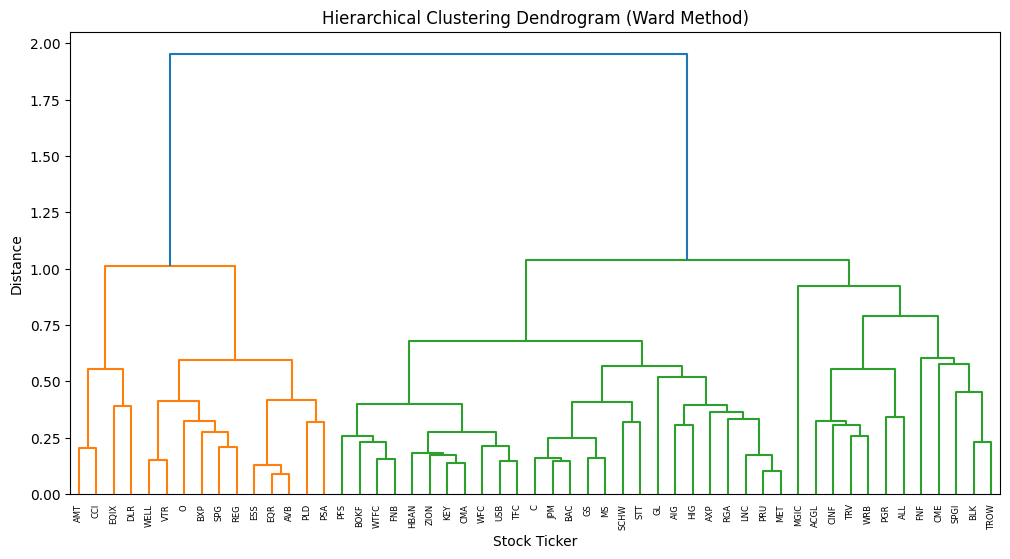

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

all_tickers = [col[0] for col in returns.columns]
corr_matrix = returns.corr()

distance_matrix = 1 - corr_matrix
condensed_distance_matrix = squareform(distance_matrix)

linkage_matrix = linkage(condensed_distance_matrix, method="ward")

# Визуализируем дендрограмму
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=all_tickers, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Ward Method)")
plt.xlabel("Stock Ticker")
plt.ylabel("Distance")
plt.show()

In [12]:
num_clusters = 4  # оптимальное число кластеров
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

cluster_dict = {all_tickers[i]: clusters[i] for i in range(len(all_tickers))}
print("\n Распределение по кластерам:")
for cluster in set(clusters):
    print(f"Кластер {cluster}: {[t for t in all_tickers if cluster_dict[t] == cluster]}")


 Распределение по кластерам:
Кластер 1: ['AMT', 'CCI', 'EQIX', 'DLR']
Кластер 2: ['PLD', 'SPG', 'PSA', 'O', 'REG', 'WELL', 'VTR', 'BXP', 'EQR', 'ESS', 'AVB']
Кластер 3: ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP', 'AIG', 'PRU', 'SCHW', 'MET', 'USB', 'HIG', 'ZION', 'TFC', 'WTFC', 'HBAN', 'FNB', 'KEY', 'BOKF', 'STT', 'CMA', 'PFS', 'LNC', 'GL', 'RGA']
Кластер 4: ['BLK', 'SPGI', 'TROW', 'CME', 'FNF', 'TRV', 'PGR', 'WRB', 'MGIC', 'CINF', 'ACGL', 'ALL']


In [18]:
cluster_asset_dict = {}
for asset in cluster_dict:
    if f"cluster_{cluster_dict[asset]}" not in cluster_asset_dict:
        cluster_asset_dict[f"cluster_{cluster_dict[asset]}"] = set()
    cluster_asset_dict[f"cluster_{cluster_dict[asset]}"].add(asset)


In [19]:
threshold = 0.85
pairs_corr_assets = {}

for cluster in cluster_asset_dict:
    data_cur = returns.loc[:, list(cluster_asset_dict[cluster])]
    corr_matrix = data_cur.corr()
    pairs_corr_assets[cluster] = [(t1[0], t2[0], corr_matrix.loc[t1[0], t2[0]].values[0])
                                  for t1 in corr_matrix.columns
                                  for t2 in corr_matrix.columns
                                  if t1[0] != t2[0] and corr_matrix.loc[t1[0], t2[0]].values[0] >= threshold]
    print(f"\nВысококоррелированные пары в кластере {cluster} (ρ > 0.85):")
    for t1, t2, corr in sorted(pairs_corr_assets[cluster], key=lambda x: -x[2]):
        print(f"{t1} - {t2}: {corr:.3f}")


Высококоррелированные пары в кластере cluster_3 (ρ > 0.85):
PRU - MET: 0.896
MET - PRU: 0.896
CMA - KEY: 0.864
KEY - CMA: 0.864
PRU - LNC: 0.857
LNC - PRU: 0.857
TFC - USB: 0.856
USB - TFC: 0.856
BAC - JPM: 0.853
JPM - BAC: 0.853

Высококоррелированные пары в кластере cluster_4 (ρ > 0.85):

Высококоррелированные пары в кластере cluster_2 (ρ > 0.85):
AVB - EQR: 0.910
EQR - AVB: 0.910
EQR - ESS: 0.883
ESS - EQR: 0.883
AVB - ESS: 0.879
ESS - AVB: 0.879
WELL - VTR: 0.850
VTR - WELL: 0.850

Высококоррелированные пары в кластере cluster_1 (ρ > 0.85):


По итогу после такой фильтрации два кластера вырождаются и остаются только cluster_3 и cluster_2 (в них довольно много пар с высоким показателем корреляции)

Теперь проведу стат тесты на наличие коинтеграции в отобранных парах в каждом кластере

In [47]:
def read_stock_data_test(ticker):
    data = yf.download(ticker, start="2010-01-01", end="2025-01-01")
    return data[["Close"]].dropna()  # Возвращаем только цены закрытия

In [52]:
from statsmodels.tsa.stattools import adfuller
from collections import defaultdict

coint_pairs = defaultdict(list)  # Словарь для хранения коинтегрированных пар

for cluster, pairs in pairs_corr_assets.items():
    for asset1, asset2, corr in pairs:
        data1 = read_stock_data_test(asset1)
        data2 = read_stock_data_test(asset2)
        spread = data1["Close"][asset1] - data2["Close"][asset2]

        # Тест Энгла-Грейнджера (ADF на спред)
        adf_test = adfuller(spread)
        p_value = adf_test[1]

        print(f"Для {asset1} и {asset2} тест Дики-Фуллера показал p_value = {p_value}")
        # Оставляем только пары со стационарным спредом
        if p_value < 0.1:
            coint_pairs[cluster].append((asset1, asset2, corr, p_value))

print(f"Найдено {sum(len(v) for v in coint_pairs.values()) / 2} коинтегрированных пар")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для TFC и USB тест Дики-Фуллера показал p_value = 0.0038508438648200524



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для PRU и MET тест Дики-Фуллера показал p_value = 0.24895956716335427



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для PRU и LNC тест Дики-Фуллера показал p_value = 0.9969335419391254



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для MET и PRU тест Дики-Фуллера показал p_value = 0.24895956716335427



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для LNC и PRU тест Дики-Фуллера показал p_value = 0.9969335419391254



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для CMA и KEY тест Дики-Фуллера показал p_value = 0.41097098358777917



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для BAC и JPM тест Дики-Фуллера показал p_value = 0.999050903625898



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для KEY и CMA тест Дики-Фуллера показал p_value = 0.41097098358777917



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для USB и TFC тест Дики-Фуллера показал p_value = 0.0038508438648200524



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для JPM и BAC тест Дики-Фуллера показал p_value = 0.999050903625898



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для AVB и EQR тест Дики-Фуллера показал p_value = 0.7228435808951537



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для AVB и ESS тест Дики-Фуллера показал p_value = 0.368924343293541



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для WELL и VTR тест Дики-Фуллера показал p_value = 0.9988828318157612



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для VTR и WELL тест Дики-Фуллера показал p_value = 0.9988828318157612



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для EQR и AVB тест Дики-Фуллера показал p_value = 0.7228435808951537



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для EQR и ESS тест Дики-Фуллера показал p_value = 0.6158938251605804



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Для ESS и AVB тест Дики-Фуллера показал p_value = 0.368924343293541


Для ESS и EQR тест Дики-Фуллера показал p_value = 0.6158938251605804
Найдено 1.0 коинтегрированных пар


По итогу при пороге уровня значимости равным 10 % прошла лишь одна пара: USB и TFC с p_value = 0.004

Еще неплохие результаты показали пары:
1. PRU и MET, p_value = 0.25
2. AVB и ESS, p_value = 0.37
3. CMA и KEY, p_value = 0.42

Ниже для примера взял абсолютно несвязанные компании, чтобы убедиться, что тест работает корректно

In [53]:
aapl_data = read_stock_data("AAPL")
xom_data = read_stock_data("XOM")

spread = aapl_data["Close"]["AAPL"] - xom_data["Close"]["XOM"]
adf_test = adfuller(spread)

print("Результаты теста Дики-Фуллера для спреда AAPL и XOM (цены закрытия):")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Критические значения:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Результаты теста Дики-Фуллера для спреда AAPL и XOM (цены закрытия):
ADF Statistic: 0.21750809831801318
p-value: 0.9732266497547213
Критические значения:
   1%: -3.4320982741938835
   5%: -2.8623124910596176
   10%: -2.567181207712407


Попробуем запустить для лучших пар из оставшихся кластеров подбор гиперпараметров и саму стратегию.

А далее попробуем усовершенствовать хэджирующую стратегию.

# Тестирование лучших пар активов

In [62]:
data1 = pd.DataFrame(returns.loc[:, 'PRU']).rename(columns={"PRU": "log_ret"})
data2 = pd.DataFrame(returns.loc[:, 'MET']).rename(columns={"MET": "log_ret"})

  0%|          | 0/500 [00:00<?, ?it/s]

Sharpe ratio = 0.76
Annual Return = 0.16
Annual Std = 0.21


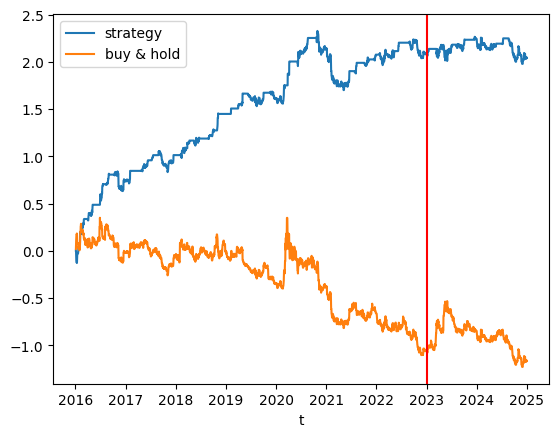

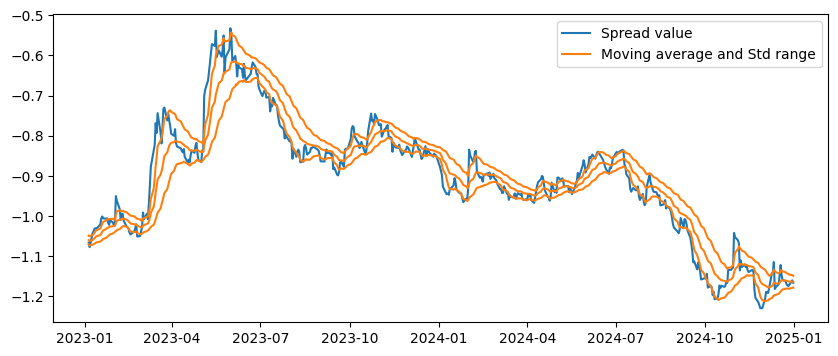

<Figure size 640x480 with 0 Axes>

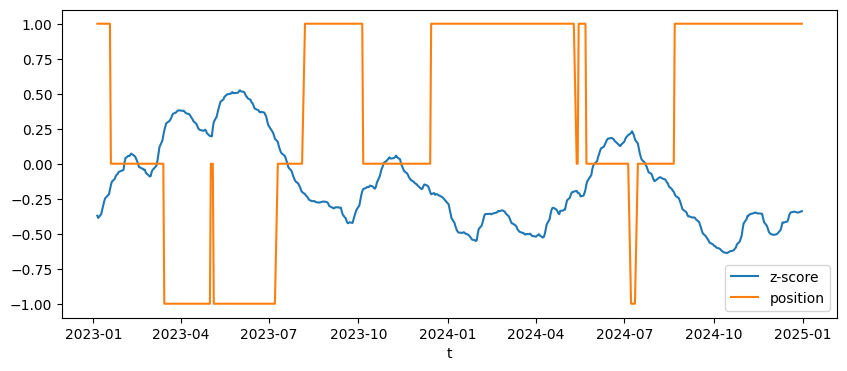

In [63]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 500, show_progress_bar = True)
params = list(study.best_params.values())

data = (data1-study.best_params['beta']*data2).dropna()
in_sample_start = '2016-01-01'
in_sample_end = '2023-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_start:]
stats, eq, _ = strategy_backtest(test, params, True, in_sample_end)


In [64]:
study.best_params

{'period': 9,
 'open_treshold': 2.034496837139073,
 'close_treshold': 0.28566660641590974,
 'period2': 64,
 'pos_limit': 1,
 'beta': 2.0263145031631704}

Берем лучшую пару из cluster_2: EQR и AVB:

In [59]:
data1 = pd.DataFrame(returns.loc[:, 'TFC']).rename(columns={"TFC": "log_ret"})
data2 = pd.DataFrame(returns.loc[:, 'USB']).rename(columns={"USB": "log_ret"})

  0%|          | 0/500 [00:00<?, ?it/s]

Sharpe ratio = 0.91
Annual Return = 0.60
Annual Std = 0.65


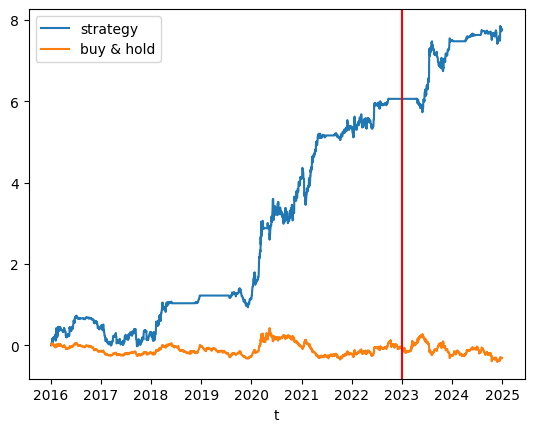

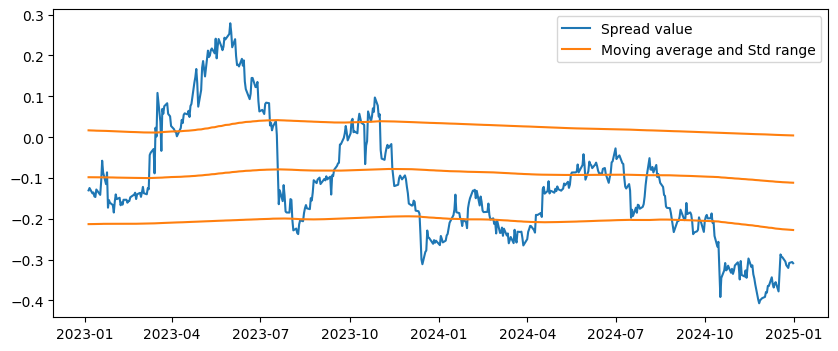

<Figure size 640x480 with 0 Axes>

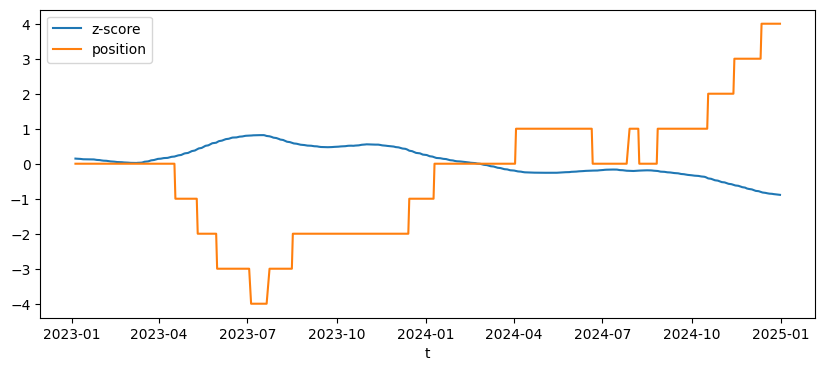

In [61]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 500, show_progress_bar = True)
params = list(study.best_params.values())

data = (data1-study.best_params['beta']*data2).dropna()
in_sample_start = '2016-01-01'
in_sample_end = '2023-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_start:]
stats, eq, _ = strategy_backtest(test, params, True, in_sample_end)


Для пары, которая представлена выше виден самый лучший результат, как и следовало ожидать из теста Дики - Фуллера

Поисследуем результаты для других пар:

In [56]:
data1 = pd.DataFrame(returns.loc[:, 'KEY']).rename(columns={"KEY": "log_ret"})
data2 = pd.DataFrame(returns.loc[:, 'CMA']).rename(columns={"CMA": "log_ret"})

  0%|          | 0/500 [00:00<?, ?it/s]

Sharpe ratio = 0.57
Annual Return = 0.29
Annual Std = 0.50


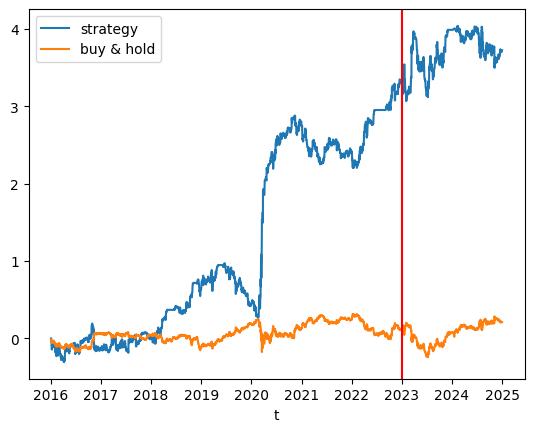

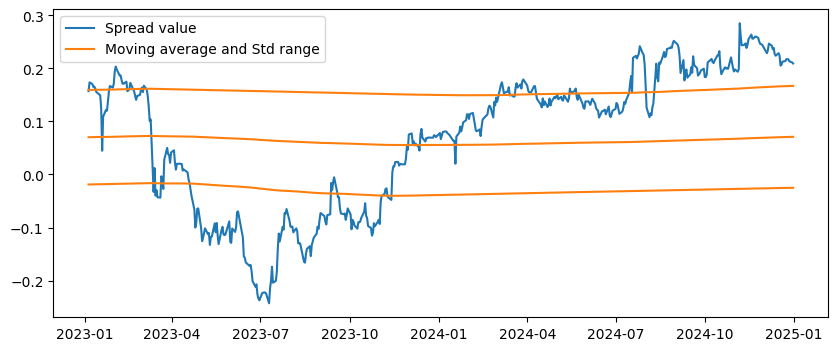

<Figure size 640x480 with 0 Axes>

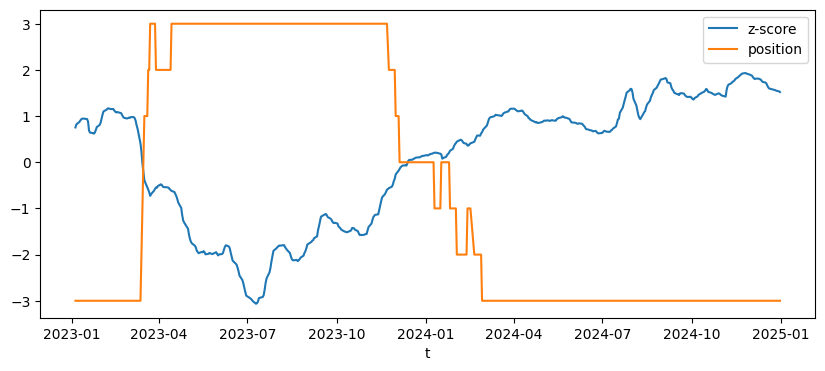

In [57]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 500, show_progress_bar = True)
params = list(study.best_params.values())

data = (data1-study.best_params['beta']*data2).dropna()
in_sample_start = '2016-01-01'
in_sample_end = '2023-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_start:]
stats, eq, _ = strategy_backtest(test, params, True, in_sample_end)


In [58]:
study.best_params

{'period': 4714,
 'open_treshold': 2.2217134423689107,
 'close_treshold': 0.3036964939697098,
 'period2': 5,
 'pos_limit': 3,
 'beta': 0.5638597396908582}

In [178]:
data1 = pd.DataFrame(returns.loc[:, 'ESS']).rename(columns={"ESS": "log_ret"})
data2 = pd.DataFrame(returns.loc[:, 'AVB']).rename(columns={"AVB": "log_ret"})

  0%|          | 0/500 [00:00<?, ?it/s]

Sharpe ratio = 0.84
Annual Return = 0.26
Annual Std = 0.30


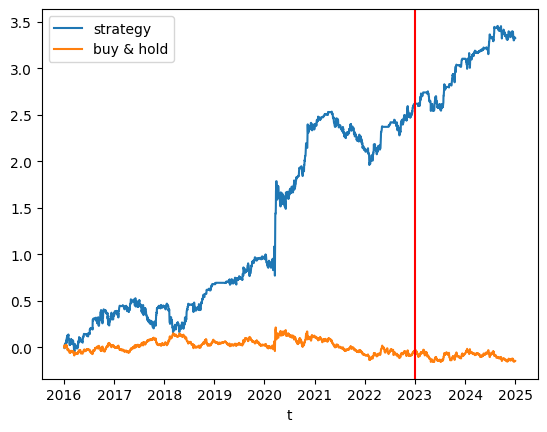

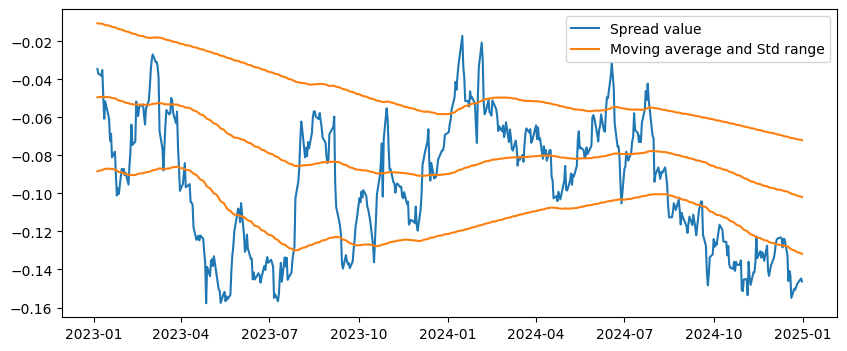

<Figure size 640x480 with 0 Axes>

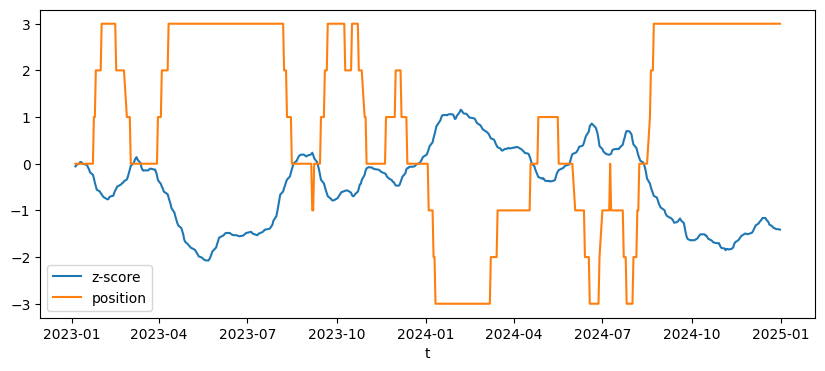

In [179]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 500, show_progress_bar = True)
params = list(study.best_params.values())

data = (data1-study.best_params['beta']*data2).dropna()
in_sample_start = '2016-01-01'
in_sample_end = '2023-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_start:]
stats, eq, _ = strategy_backtest(test, params, True, in_sample_end)


In [180]:
study.best_params

{'period': 160,
 'open_treshold': 2.934897984127591,
 'close_treshold': 0.2221838680693205,
 'period2': 10,
 'pos_limit': 3,
 'beta': 1.2647254995164656}

# Динамический выбор пар активов

In [49]:
from statsmodels.tsa.stattools import coint

def find_best_pair(price_data):
    """Находит лучшую пару активов на основе коинтеграции"""
    pairs = []
    assets = price_data.columns
    for i in range(len(assets)):
        for j in range(i+1, len(assets)):
            _, pvalue, _ = coint(price_data.iloc[:,i], price_data.iloc[:,j])
            pairs.append((assets[i], assets[j], pvalue))
    return sorted(pairs, key=lambda x: x[2])[0]  # Возвращаем пару с наименьшим p-value

def read_data(ticker, log=True):
    data = yf.download(ticker, start="2010-01-01", end="2024-01-01")
    if log:
        data["log_ret"] = np.log(data["Close"]).diff()
        return pd.DataFrame(data["log_ret"].dropna())
    #data["close"] = data["Close"]
    return pd.DataFrame(data["Close"].dropna())


In [51]:
from sklearn.linear_model import LinearRegression

# Функция для расчета beta
def calculate_beta(data1, data2):
    """Рассчитывает beta с помощью линейной регрессии"""
    model = LinearRegression()
    model.fit(data2.values.reshape(-1, 1), data1.values)
    return model.coef_[0]


In [107]:
def strategy_backtest(data, params, plot = False, in_sample_end = '', slippage = 0.0005, plot_position = True):
    """
    Strategy backtest calculation

    :data: dataframe with log returns
    :params: list of strategy parameters
    :plot: if True than equity curve is plotted
    :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
    :slippage: slippage per trade
    :plot_position: if True than position values is plotted
    :return: statistics and equity curve
    """

    # Strategy parameters that we will optimize
    period = params[0]
    open_treshold = params[1]
    close_treshold = params[1]*params[2]

    period2 = params[3]

    pos_limit =  params[4]
    coint_period = params[5]

    # Calculation of target position:
    features = pd.DataFrame(index = data.index)
    for i in range(coint_period, len(data)):
        best_pair = find_best_pair(data.iloc[i-coint_period:i])
        cur_date = data.index[i]
        #print('data', cur_date)
        asset1, asset2, _ = best_pair
        data1 = pd.DataFrame(data[asset1])
        data2 = pd.DataFrame(data[asset2])
        
        data1["log_ret"] = np.log(data1[asset1]).diff().dropna()
        data1 = pd.DataFrame(data1["log_ret"].dropna())

        data2["log_ret"] = np.log(data2[asset2]).diff().dropna()
        data2 = pd.DataFrame(data2["log_ret"].dropna())
        
        cur_beta = calculate_beta(data1, data2)[0]

        #print(i, asset1, asset2, cur_beta)
        data_cur = data1 - cur_beta * data2
        spread = (data1["log_ret"] - cur_beta * data2["log_ret"]).dropna().cumsum()
        
        spread_mean = spread.ewm(span=period).mean()
        spread_std = np.abs(spread - spread_mean).ewm(span=period).mean()
        z_score = (spread - spread_mean) / spread_std
        # 6. Расчет позиции
        position = 5*(-z_score).ewm(period2).mean().shift(1).fillna(0).astype(int) # Позиция на основе последнего значения z-оценки
        #print('fdsfs', position.index[i])
        position = np.clip(position.loc[cur_date], -pos_limit, pos_limit)  # Ограничение позиции
        #print(i, position, data.index[i], z_score.index[i])
        features.loc[cur_date, 'position'] = position

        
    
    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')
    bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

    turnover = features['position'].diff().abs().sum()

    # We calculate statistics and save the result
    stats = statistics_calc(eq, bh, name = "{0}_{1}_{2}".format(period, open_treshold, close_treshold), plot = plot)

    # Draw a graph of position changes, if necessary
    if (plot) and (plot_position):

        if in_sample_end != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

        period_to_plot = 500
        plt.figure(figsize = (10, 4))
        plt.plot(features['spread'][-period_to_plot:], label = 'Spread value')
        plt.plot(features['spread_mean'][-period_to_plot:], color = 'tab:orange')
        plt.plot((features['spread_mean']+features['spread_std'])[-period_to_plot:], color = 'tab:orange', label = 'Moving average and Std range')
        plt.plot((features['spread_mean']-features['spread_std'])[-period_to_plot:], color = 'tab:orange')
        plt.legend()

        plt.figure()
        plt.figure(figsize = (10, 4))
        plt.plot(features['z_score'].ewm(period2).mean()[-period_to_plot:], label = 'z-score')

        position_to_plot = features['position'][-period_to_plot:]
        plt.plot(position_to_plot, label = 'position')
        plt.xlabel('t')
        plt.legend()

    return stats, eq, turnover

In [69]:
def opt_backtest(train, params):
    stats_current, *_ = strategy_backtest(train, params)
    return stats_current['Sharpe ratio'].iloc[0]

In [73]:
def objective(trial):

    period = trial.suggest_int("period", 5, 5000, log = True)
    open_treshold = trial.suggest_float("open_treshold", 1.0, 3.0)
    close_treshold = trial.suggest_float("close_treshold", 0.0005, 0.8)
    period2 = trial.suggest_int("period2", 5, 2000, log = True)

    pos_limit = trial.suggest_int("pos_limit", 1, 5)
    coint_period = trial.suggest_int("coint_period", 30, 365)
    
    assets = ["TFC", "USB", "PRU", "MET", "KEY"]
    price_data = pd.DataFrame(yf.download(assets, start="2010-01-01", end="2024-01-01")['Close'].dropna())
    
    # Разделение на тренировочный и тестовый периоды
    in_sample_start = '2015-01-01'
    in_sample_end = '2022-01-01'

    train = price_data[in_sample_start:in_sample_end]
    
    obj_value = opt_backtest(train, [period, open_treshold, close_treshold, period2, pos_limit, coint_period])
    
    if np.isnan(obj_value):
        obj_value = 0

    return obj_value


In [ ]:
# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, show_progress_bar=True)

# Финальный бэктест на лучших параметрах
best_params = study.best_params
price_data = yf.download(["TFC", "USB", "PRU", "MET", "KEY"], 
                        start="2010-01-01", end="2024-01-01")['Close']
stats, equity = strategy_backtest(price_data, best_params, plot=True)

print(f"Результаты стратегии:")
print(stats)

Работает долго из-за того, что мы на каждом шаге пересчитываем параметры, так как бетта и пара активов динамическая. И у меня не до конца получилось это сделать успешно.